In [1]:
%pylab inline
import random

import numpy as np
import random
import pickle
from tqdm import tqdm
import letor_metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
raw_data = np.loadtxt('./data/ml-1m/ratings.dat', delimiter='::')

In [3]:
from dataset import TripletsDataset

In [4]:
ds = TripletsDataset(raw_data, threshold_user=30, rnd_seed=42)
ds.train_test_split(n_train=20)

Split users:  11%|█         | 563/5286 [00:00<00:01, 2817.76it/s]

In [5]:
len(ds.statistics['items'])

3416

In [6]:
pickle.dump(ds, open('./tmp/ds.pkl', 'wb'))
# ds = pickle.load(open('./tmp/ds.pkl', 'rb'))

# define model

In [7]:
import tensorflow as tf
from bprmf import BPR_MF

In [ ]:
#  model.destroy()

In [8]:
N_USERS = 6041 #int(max(raw_data[:, 0])) + 1
N_ITEMS = 3953 #int(max(raw_data[:, 1])) + 1
N_EMBEDDINGS= 10

In [9]:
model = BPR_MF(N_USERS, N_ITEMS, N_EMBEDDINGS, alpha_reg=0.01)
model.build_graph()
model.initialize_session()

In [10]:
losses = []
batch_size = 1024
for n_batches, cur_optim in [(5000, model.trainer_2)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            model.user_ids:  batch['users'], 
            model.left_ids:  batch['left_items'],
            model.right_ids: batch['right_items'],
            model.target_y:  batch['y'],
        }
        el, reg, t, _ = model.session.run(
            [model.embedding_loss, model.regularization, model.target, cur_optim], 
            feed_dict=fd
        )
        losses.append((el, reg, t))
        if i%5000==0:
            user_norm = np.linalg.norm(model.weights_u)
            item_norm = np.linalg.norm(model.weights_i)
            print('[it {}] weight norms, users: {}, items: {}'.format(i, user_norm, item_norm))

  0%|          | 13/5000 [00:00<01:48, 45.77it/s]

[it 0] weight norms, users: 114.60042572021484, items: 141.36692810058594


100%|██████████| 5000/5000 [00:52<00:00, 95.18it/s] 


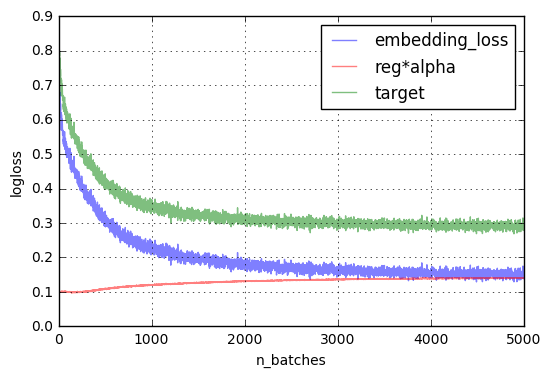

In [11]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1]*model.alpha_reg for x in losses], c='r', label='reg*alpha', alpha=0.5)
plot([x[2] for x in losses], c='g', label='target', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [12]:
ndcg_vals = []
for u in tqdm(ds.data_keys, desc='Prediction', leave=True):
    fd = {
            model.user_ids:  (np.ones(N_ITEMS)*u).astype(np.int32), 
            model.left_ids:  np.array([i for (i, r) in ds.test[u]]).astype(np.int32),
        }
    response = model.session.run(model.embedding_left, feed_dict=fd)[:, 0]

    # make relevances
    relevances = np.array([r for (i, r) in ds.test[u]])
    predicted_ranking = np.argsort(-response)
    # calc score
    gain = letor_metrics.ndcg_from_ranking(relevances, predicted_ranking, 10)
    ndcg_vals.append(gain)

Prediction: 100%|██████████| 5286/5286 [00:03<00:00, 1751.13it/s]


In [13]:
np.mean(ndcg_vals)

0.61520973806837964